# Image segmentaion with masked facies

Squish rectangular images to square

Using mask images processed in 01_02_mask_processing

512x512 size - images cropped - generated in 01_03_image_mask_cropping
reduced to 256x256 in transforms

Using 2200x512 sized imaged from mpl that have been cropped

Resizing 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid
from scipy.stats import mode

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(2)

In [5]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: ea2fc400, DATE: 20191222


In [6]:
UID='dfdf95a0'
DATE='20191222'
NB='02_10_0'
DESCR='rn34'

In [7]:
SUBSET_DATA=False
SUBSET_LEN=171
VALIDATION_FILE='val_20pct_0.csv'

#training image size
TGT_HEIGHT_SMALL = 128
TGT_HEIGHT_MEDIUM = 256
TGT_HEIGHT_FULL = 512

In [8]:
data_dir = Path('../data')
train_images = data_dir/'train_images'
train_path = train_images/'cropped_512/train'
train_mask = train_path/'masks'
train_img = train_path/'images'

test_img = train_images/'test'

In [9]:
filename = data_dir/'CAX_LogFacies_Train_File.csv'

In [10]:
file_test = data_dir/'CAX_LogFacies_Test_File.csv'

#### all data

In [11]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()

,0
0,well_0.png
1,well_1.png
2,well_2.png
3,well_3.png
4,well_4.png


In [12]:
test_df = pd.read_csv(file_test)
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


### Data

In [13]:
train_img

PosixPath('../data/train_images/cropped_512/train/images')

In [14]:
train_img_names = get_image_files(train_img)
len(train_img_names)

32000

In [15]:
train_img_names[:3]

[PosixPath('../data/train_images/cropped_512/train/images/well_3666_crop_3.png'),
 PosixPath('../data/train_images/cropped_512/train/images/well_3886_crop_6.png'),
 PosixPath('../data/train_images/cropped_512/train/images/well_2037_crop_6.png')]

#### Cropped images

In [16]:
for im in train_img_names:
    assert 'crop' in str(im)

In [17]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('../data/train_images/cropped_512/train/masks/well_3666_crop_3.png'),
 PosixPath('../data/train_images/cropped_512/train/masks/well_3886_crop_6.png'),
 PosixPath('../data/train_images/cropped_512/train/masks/well_2037_crop_6.png')]

In [18]:
for im in train_mask_names:
    assert 'crop' in str(im)

### Data QC

In [19]:
inames=[]
mnames=[]
for im in train_img_names:
    inames.append(im.name)
for im in train_mask_names:
    mnames.append(im.name)

In [20]:
train_img_names[0]

PosixPath('../data/train_images/cropped_512/train/images/well_3666_crop_3.png')

In [21]:
missing_i_m=set(inames) - set(mnames)

In [22]:
missing_m_i= set(mnames)-set(inames) 

In [23]:
#assert len(missing_i_m)==len(missing_m_i)==0

In [24]:
len(inames)

32000

In [25]:
len(mnames)

32000

In [26]:
inames.sort()
mnames.sort()

In [27]:
len(inames)

32000

In [28]:
for im,mm in zip(inames, mnames):
    assert im==mm
    img=train_img/f'{im}'
    mmg=train_mask/f'{mm}'
    img_ =pil_image.open(img)
    mmg_ =pil_image.open(mmg)
    if img_.size != mmg_.size:
        print(f'img_.size: {img_.size} != mmg_.size: {mmg_.size}')

In [29]:
train_img_names[100]

PosixPath('../data/train_images/cropped_512/train/images/well_1193_crop_3.png')

../data/train_images/cropped_512/train/images/well_1193_crop_3.png


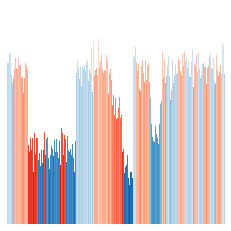

In [30]:
img_f = train_img_names[100]
print(img_f)
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

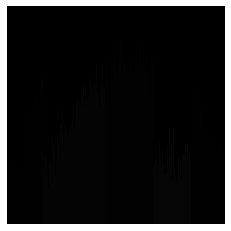

In [31]:
mask_f = train_mask_names[0]
mask_gr = open_image(mask_f)
mask_gr.show(figsize=(18,4))

### Link Masks with Images

In [32]:
get_y_fn = lambda x: train_mask/f'{x.stem}{x.suffix}' # converts from image to mask file name

In [33]:
get_y_fn(img_f)

PosixPath('../data/train_images/cropped_512/train/masks/well_1193_crop_3.png')

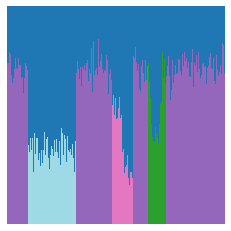

In [34]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(18,4), alpha=1)

In [35]:
u_values=[]
def get_all_uniques(images, subset=None):
    for i, im in enumerate(images):
        if subset and (i > subset):
            return u_values
        mask = np.asarray(pil_image.open(im))
        u_values.extend(np.unique(mask.tolist()))
    return u_values

In [36]:
#u_values=list(set(get_all_uniques(train_mask_names, 100)))
#u_values.sort()
#print(u_values)

Note that not all colours are mapped by fastai - we need to do this manually

### Log Facies

<pre>
            ▪ 0 (None), 
            ▪ 1 (Symmetrical), Hour glass (Prograding and retrograding)
            ▪ 2 (Cylindrical) Blocky sst (Aggrading)
            ▪ 3 (Funnel) Coarsening up (Prograding)
            ▪ 4 (Bell) Fining up (Retrograding)
</pre>



In [37]:
#codes = array(['Background', 'None', 'Symmetrical', 'Cylindrical', 'Funnel', 'Bell'])
codes = array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'])

In [38]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([512, 512]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]]))

In [39]:
gr_size = np.array(img_gr.shape[1:])
gr_size,img_gr.data

(array([512, 512]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.6275, 0.7608, 0.7608,  ..., 0.7020, 0.7020, 0.6784],
          [0.6275, 0.7608, 0.7608,  ..., 0.7020, 0.7020, 0.6784],
          [0.6275, 0.7608, 0.7608,  ..., 0.7020, 0.7020, 0.6784]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7961, 0.8510, 0.8510,  ..., 0.8275, 0.8275, 0.8157],
          [0.7961, 0.8510, 0.8510,  ..., 0.8275, 0.8275, 0.8157],
          [0.7961, 0.8510, 0.8510,  ..., 0.8275, 0.8275, 0.8157]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1

## Datasets

First try using small (re)sized images

In [40]:
#Uses 4.3 GB VRAM at bs=32
bs = 32

size=(TGT_HEIGHT_SMALL, TGT_HEIGHT_SMALL)

In [41]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1.1, max_lighting=0.0, \
                    max_warp=0., p_affine=0., p_lighting=0.0)

In [42]:
src = (SegmentationItemList.from_folder(path=train_img)
    .split_by_fname_file(f'../{VALIDATION_FILE}', path=train_img)
    .label_from_func(get_y_fn, classes=codes))

In [43]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [44]:
len(src.train.x)

25600

In [45]:
#src_test = (SegmentationItemList.from_folder(path=train_img)
#    .label_empty()
#    .split_none()
#    .add_test_folder(test_folder='../../test', tfms=None, tfm_y=False))

In [46]:
#data_test = (src_test.transform(size=size, tfms=None, tfm_y=False)
#        .databunch(bs=bs)
#        .normalize(imagenet_stats))

In [47]:
data.train_ds.x[0].shape

torch.Size([3, 512, 512])

In [48]:
#data_test.valid_ds.x[0].shape

In [49]:
data.train_ds.y[0].shape

torch.Size([1, 512, 512])

In [50]:
uy=[]
def get_unique_y_vals(data_list):
    for yt in data_list:
        y=yt.data.numpy()
        uy.extend(np.unique(y.tolist()))
    return uy

In [51]:
#u_values=list(set(get_unique_y_vals(data.train_ds.y)))
#u_values.sort()
#print(u_values)

In [52]:
#y=data.train_ds.y[0].data.numpy()

In [53]:
#np.unique(y)

In [54]:
data.label_list

LabelLists;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: ../data/train_images/cropped_512/train/images;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: ../data/train_images/cropped_512/train/images;

Test: None

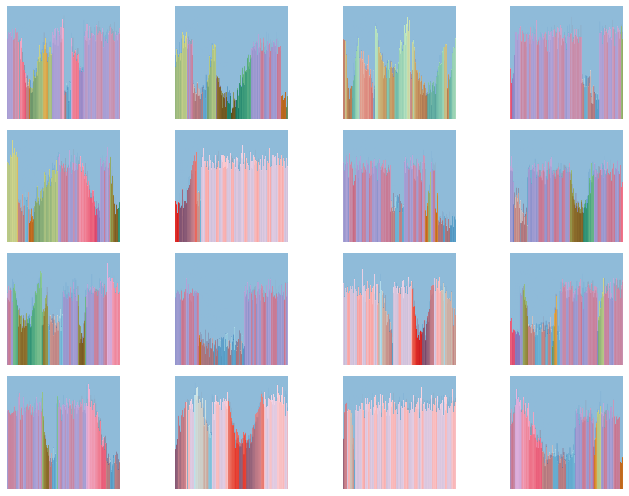

In [55]:
data.show_batch(4, figsize=(10,7))

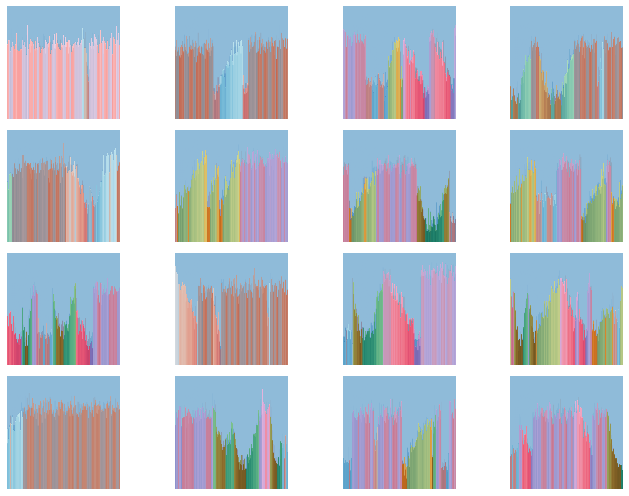

In [56]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

### Model

Eval criterion:
    
Classification Accuracy (percentage of correctly predicted rows)

In [57]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

Create an accuaracy metric that ignores the region above (when log is displayed horizontally) the GR log values

In [58]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
print(void_code)

def acc_bgvoid(input, target):
    #print(f'in: {input.shape}, tgt: {target.shape}')
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

0


In [104]:
learn.metrics

[<function __main__.acc_bgvoid(input, target)>]

In [59]:
data

ImageDataBunch;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: ../data/train_images/cropped_512/train/images;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: ../data/train_images/cropped_512/train/images;

Test: None

In [60]:
wd=1e-2

In [61]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=acc_bgvoid, wd=wd).to_fp16()

In [62]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

In [63]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [64]:
#learn.loss_func=dice
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [65]:
#learn.pred_batch()

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


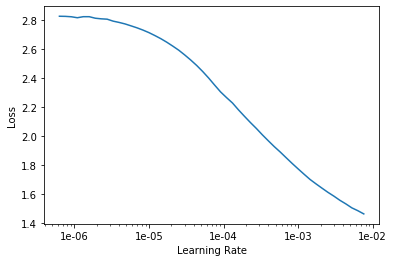

In [67]:
learn.recorder.plot()

In [68]:
lr=3e-4

In [69]:
learn.fit(3, lr)

epoch,train_loss,valid_loss,acc_bgvoid,time
0,0.163971,0.155799,0.908108,02:32
1,0.134516,0.132650,0.928062,02:38
2,0.114263,0.133660,0.920290,02:29


In [70]:
learn.save(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s1-r0-{DATE}')

In [71]:
learn.fit(3, lr)

epoch,train_loss,valid_loss,acc_bgvoid,time
0,0.101005,0.118097,0.929489,02:30
1,0.089505,0.114888,0.931800,02:32
2,0.075973,0.119917,0.936362,02:33


In [72]:
learn.save(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s1_1-r0-{DATE}')

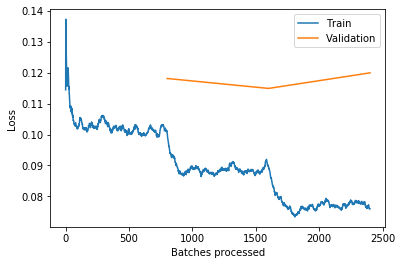

In [73]:
learn.recorder.plot_losses()

### Re-train

In [74]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


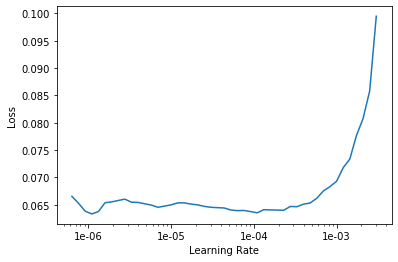

In [75]:
learn.lr_find()
learn.recorder.plot()

In [76]:
learn.fit(2, 5e-6)

epoch,train_loss,valid_loss,acc_bgvoid,time
0,0.058359,0.114959,0.939443,02:46
1,0.054435,0.117738,0.940139,02:50


In [77]:
learn.save(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s2-r0-{DATE}')

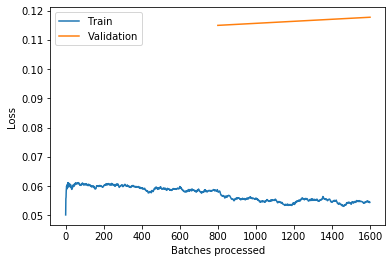

In [78]:
learn.recorder.plot_losses()

In [98]:
learn=learn.to_fp32()

In [100]:
learn.path

PosixPath('../data/train_images/cropped_512/train/images')

In [101]:
learn.export(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s2-r0-{DATE}.pkl')

### Loss QC

In [79]:
learn.load(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s2-r0-{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: ../data/train_images/cropped_512/train/images;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: ../data/train_images/cropped_512/train/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [97]:
print(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s2-r0-{DATE}')

02_10_0-dfdf95a0_rn34_128-s2-r0-20191222


In [80]:
learn.data.classes

array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'], dtype='<U11')

In [81]:
interp=SegmentationInterpretation.from_learner(learn)

In [82]:
top_losses, top_idxs=interp.top_losses((TGT_HEIGHT_SMALL,TGT_HEIGHT_SMALL))

In [83]:
top_losses, top_idxs

(tensor([1.4021, 1.2197, 1.1189,  ..., 0.0045, 0.0042, 0.0041]),
 tensor([4705,  599, 3819,  ...,  780, 3568,  672]))

In [84]:
top_losses.shape

torch.Size([6400])

In [85]:
top_idxs.shape

torch.Size([6400])

In [86]:
top_idxs[:20]

tensor([4705,  599, 3819,  234, 1718,  380, 6273, 3190, 5385, 5978, 1802,  477,
        2236, 1546, 2285, 4722, 4410,  663, 1328, 4731])

In [87]:
tnp=top_idxs.numpy()
idxs=tnp[tnp<800]

tensor(0.2714)


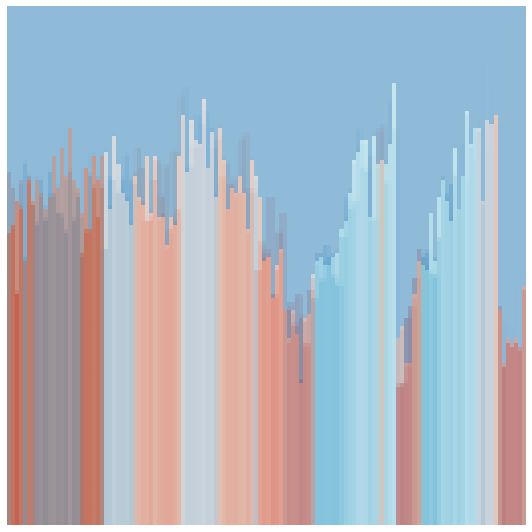

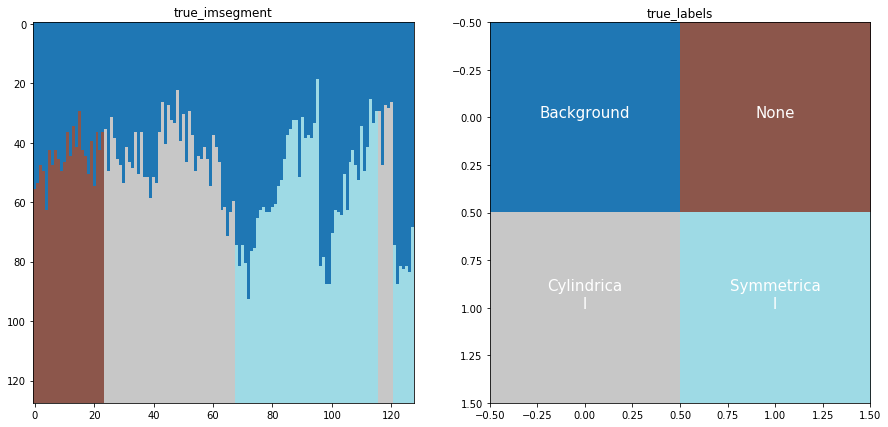

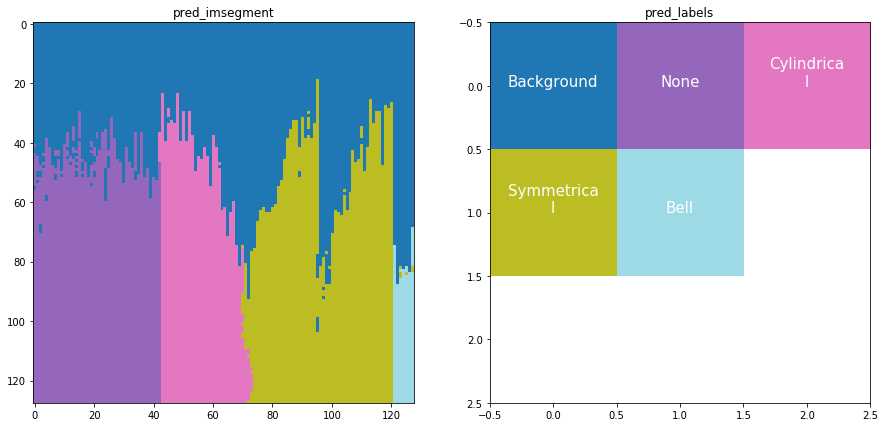

In [88]:
# show top loss
print(top_losses[idxs[0]])
interp.show_xyz(idxs[0], codes, sz=15)

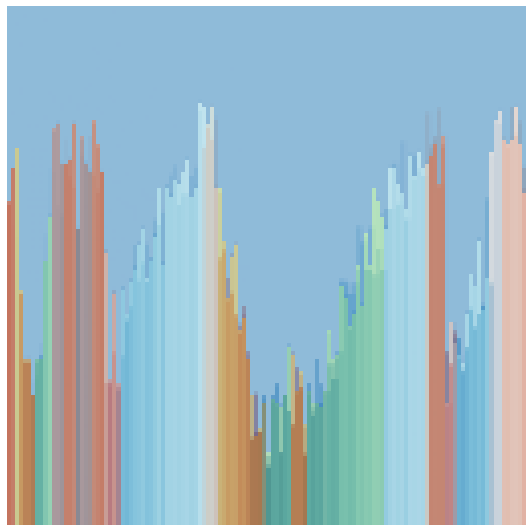

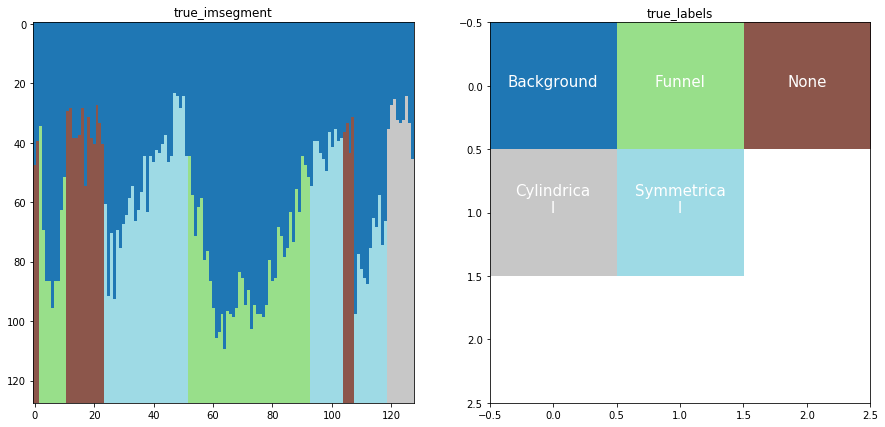

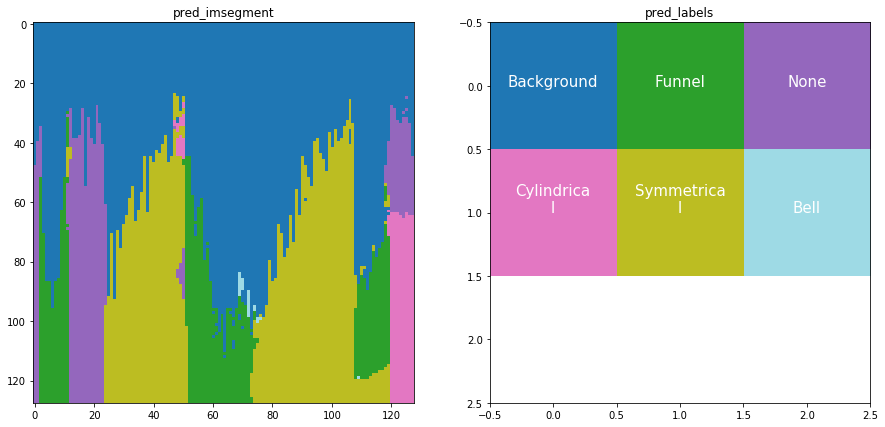

In [89]:
interp.show_xyz(idxs[3], codes, sz=15)

### Loss Distribution

(array([3.157e+03, 1.605e+03, 7.120e+02, 3.740e+02, 2.110e+02, 1.310e+02, 7.700e+01, 5.100e+01, 3.000e+01, 2.300e+01,
        6.000e+00, 1.000e+01, 5.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.004133, 0.074033, 0.143933, 0.213834, 0.283734, 0.353634, 0.423535, 0.493435, 0.563335, 0.633236, 0.703136,
        0.773036, 0.842937, 0.912837, 0.982737, 1.052638, 1.122538, 1.192438, 1.262339, 1.332239, 1.40214 ],
       dtype=float32),
 <a list of 20 Patch objects>)

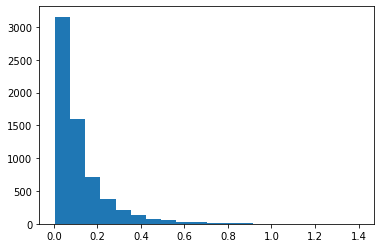

In [90]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [91]:
# top loss idxs of images
top_idxs[:5]

tensor([4705,  599, 3819,  234, 1718])

In [92]:
mean_cm, single_img_cm = interp._generate_confusion()

In [93]:
mean_cm.shape, single_img_cm.shape

((6, 6), (6400, 6, 6))

label,score
Background,0.98809
None,0.96552
Bell,0.863817
Cylindrical,0.813894
Symmetrical,0.79742
Funnel,0.784468


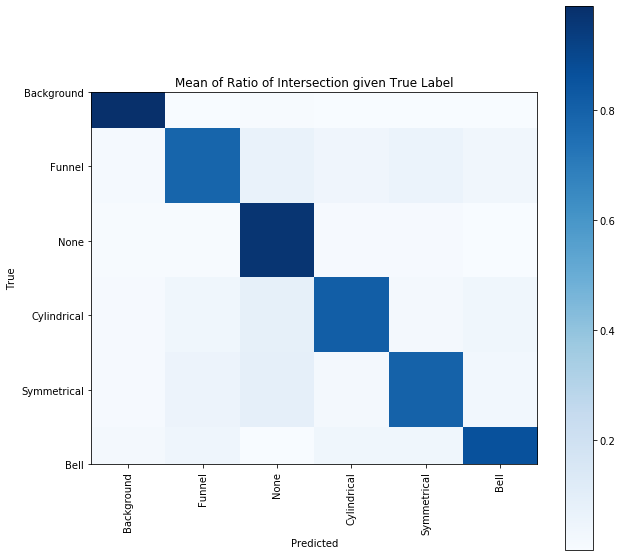

In [94]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

label,score
Background,0.988495
None,0.979342
Funnel,0.967532
Bell,0.836782
Cylindrical,NaN
Symmetrical,NaN


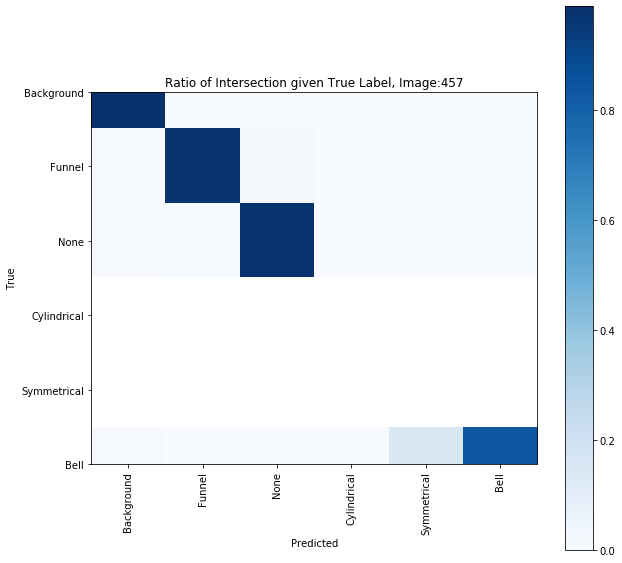

In [95]:
# single image class performance
i = 457
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

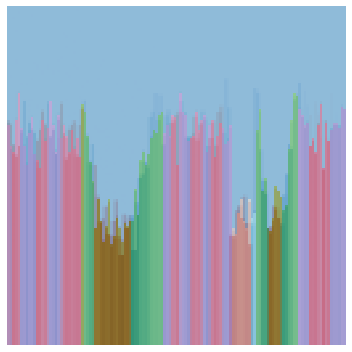

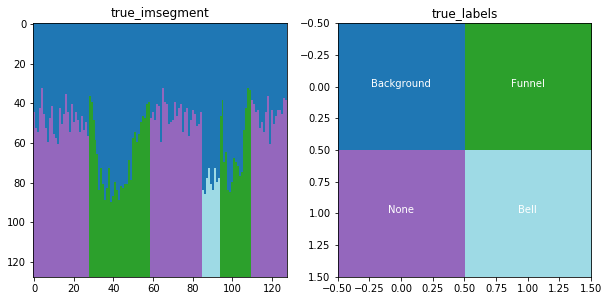

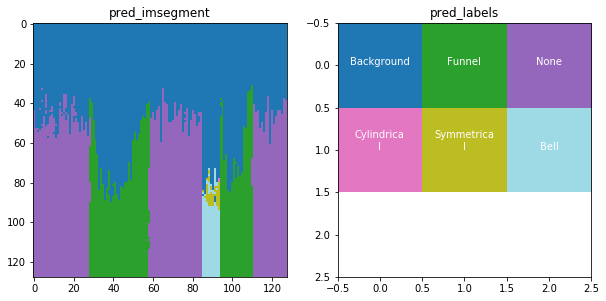

In [96]:
# show xyz
interp.show_xyz(i)